In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from monai.data import DataLoader, Dataset

import sys
# import itk

import SimpleITK as sitk
import time

import torch
# import segmentation_models_pytorch as smp
from torch.nn.functional import one_hot

from tqdm import tqdm
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
import torch.nn.functional as F

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.metrics import MeanIoU
from monai.metrics import ConfusionMatrixMetric
from monai.metrics import get_confusion_matrix, compute_confusion_matrix_metric

2023-08-17 05:12:39.393986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 05:12:40.340245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/environment/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.cuda as cuda

# 检查CUDA是否可用并获取GPU数量
device_count = cuda.device_count()
print(f"Number of available GPUs: {device_count}")

# 获取每个GPU的名称
for i in range(device_count):
    device_name = cuda.get_device_name(i)
    print(f"GPU {i+1}: {device_name}")

# 获取每个GPU的显存容量
for i in range(device_count):
    device_properties = cuda.get_device_properties(i)
    print(f"GPU {i+1} Memory: {device_properties.total_memory / 1024 / 1024} MB")

device = torch.device("cuda")

Number of available GPUs: 4
GPU 1: NVIDIA GeForce RTX 4090
GPU 2: NVIDIA GeForce RTX 4090
GPU 3: NVIDIA GeForce RTX 4090
GPU 4: NVIDIA GeForce RTX 4090
GPU 1 Memory: 24217.3125 MB
GPU 2 Memory: 24217.3125 MB
GPU 3 Memory: 24217.3125 MB
GPU 4 Memory: 24217.3125 MB


In [3]:
# class Kit19Set(Dataset):
#     def __init__(self, datapath, new_size, augmentation=None, preprocessing=None):
#         self.datapath = datapath
#         self.new_size = new_size
#         self.augmentation = augmentation
#         self.preprocessing = preprocessing

#     def __getitem__(self, i):
#         input_img_path = self.datapath+f"/case_{i:05d}/imaging.nii.gz"
#         input_seg_path = self.datapath+f"/case_{i:05d}/segmentation.nii.gz"

#         input_image = sitk.ReadImage(input_img_path)

#         # Get the current spacing and size of the input image
#         input_spacing = input_image.GetSpacing()
#         input_size = input_image.GetSize()

#         # Compute the desired spacing based on the new size
#         new_spacing = [old_sz * old_spc / new_sz for old_sz, old_spc, new_sz in
#                        zip(input_size, input_spacing, self.new_size)]

#         # Create the resampling transformation
#         resampler = sitk.ResampleImageFilter()
#         resampler.SetSize(self.new_size)
#         resampler.SetOutputSpacing(new_spacing)
#         resampler.SetOutputOrigin(input_image.GetOrigin())
#         resampler.SetOutputDirection(input_image.GetDirection())

#         # Perform the resampling
#         output_image = resampler.Execute(input_image)
#         output_image = sitk.GetArrayFromImage(output_image)
#         output_image = output_image.astype(np.float32)
#         output_image = np.transpose(output_image, (2, 1, 0))
#         output_image = torch.tensor(output_image)

#         input_mask = sitk.ReadImage(input_seg_path)

#         # Get the current spacing and size of the input mask
#         input_spacing = input_mask.GetSpacing()
#         input_size = input_mask.GetSize()

#         # Compute the desired spacing based on the new size
#         new_spacing = [old_sz * old_spc / new_sz for old_sz, old_spc, new_sz in
#                        zip(input_size, input_spacing, self.new_size)]

#         # Create the resampling transformation
#         resampler = sitk.ResampleImageFilter()
#         resampler.SetSize(self.new_size)
#         resampler.SetOutputSpacing(new_spacing)
#         resampler.SetOutputOrigin(input_mask.GetOrigin())
#         resampler.SetOutputDirection(input_mask.GetDirection())

#         # Perform the resampling
#         output_mask = resampler.Execute(input_mask)
#         output_mask = sitk.GetArrayFromImage(output_mask)
#         output_mask = output_mask.astype(np.float32)
#         output_mask = np.transpose(output_mask, (2, 1, 0))
#         # u = np.unique(output_mask)
#         # print(output_mask.shape)
#         # print(u)
#         output_mask = torch.tensor(output_mask)
#         # print(torch.sum(torch.eq(output_mask, 2)))
#         output_mask = one_hot(output_mask.long(), 3)
#         # print(output_mask.shape)
#         output_mask = output_mask.permute(3, 0, 1, 2)
#         # u = np.unique(output_mask)
#         # print(u)
#         # print(output_mask.shape)
#         # print(torch.all(output_mask[0] == 1))
#         # print(torch.all(output_mask[1] == 0))
#         # print(torch.all(output_mask[2] == 0))
        
#         # print(torch.sum(torch.eq(output_mask[0], 1)))
#         # print(torch.sum(torch.eq(output_mask[1], 1)))
#         # print(torch.sum(torch.eq(output_mask[2], 1)))
#         # print(torch.equal(tensor1, tensor2))

#         if self.augmentation:
#             sample = self.augmentation(image=output_image, mask=output_mask)
#             output_image, output_mask = sample['image'], sample['mask']

#         if self.preprocessing:
#             sample = self.preprocessing(image=output_image, mask=output_mask)
#             output_image, output_mask = sample['image'], sample['mask']

#         return output_image, output_mask

#     def __len__(self):
#         return int(210)




class Kit19Set(Dataset):
    def __init__(self, datapath, augmentation=None, preprocessing=None):
        self.datapath = datapath
        # self.new_size = new_size
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        input_img_path = self.datapath+f"/case_{i:05d}/imaging.nii.gz"
        input_seg_path = self.datapath+f"/case_{i:05d}/segmentation.nii.gz"

        input_image = sitk.ReadImage(input_img_path)
        output_image = sitk.GetArrayFromImage(input_image)
        output_image = output_image.astype(np.float32)
        output_image = np.transpose(output_image, (2, 1, 0))
        output_image = torch.tensor(output_image)

        input_mask = sitk.ReadImage(input_seg_path)
        output_mask = sitk.GetArrayFromImage(input_mask)
        output_mask = output_mask.astype(np.float32)
        output_mask = np.transpose(output_mask, (2, 1, 0))

        output_mask = torch.tensor(output_mask)
        output_mask = one_hot(output_mask.long(), 3)
        output_mask = output_mask.permute(3, 0, 1, 2)


        if self.augmentation:
            sample = self.augmentation(image=output_image, mask=output_mask)
            output_image, output_mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=output_image, mask=output_mask)
            output_image, output_mask = sample['image'], sample['mask']

        return output_image, output_mask

    def __len__(self):
        return int(210)

In [4]:
new_size = [64, 128, 128]

dataset = Kit19Set("./data/resized_data_64_128")
# dataset = Kit19Set("resized_data")
train_size = int(0.8 * len(dataset))
vali_size = len(dataset) - train_size

# Use seed at 0 for reproducibility
torch.manual_seed(0)
train_dataset, vali_dataset = torch.utils.data.random_split(dataset, [train_size, vali_size])

In [5]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=48)
vali_loader = DataLoader(vali_dataset, batch_size=1, shuffle=True, num_workers=48)

In [6]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=3,
)
if device_count > 1:
    model = nn.DataParallel(model)
    print(f"Use {device_count} GPUs to train.")

model.to(device)
print(f"Use {device_count} GPUs to train.")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 542MB/s]


Use 4 GPUs to train.
Use 4 GPUs to train.


In [7]:
loss_function = DiceLoss(include_background=False).to(device)

train_dice_metric = DiceMetric(include_background=False, reduction="mean")
vali_dice_metric = DiceMetric(include_background=False, reduction="mean")

train_mean_iou_metric = MeanIoU(include_background=False, reduction="mean")
vali_mean_iou_metric = MeanIoU(include_background=False, reduction="mean")

# train_conf_matrix = ConfusionMatrixMetric(include_background=False, reduction="mean")


# loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
torch.cuda.empty_cache()
# torch.autograd.set_detect_anomaly(True)
start = time.time()

best_loss = float('inf')
train_loss_list, vali_loss_list = [], []
train_dice_list, vali_dice_list = [], []
train_iou_list, vali_iou_list = [], []

epoch = 100
true_epoch = 0

slice_batch = 8

for e in range(epoch):
    model.train()

    train_loss = 0.0
    cm_list = []
    # iou = 0
    train_dice_metric.reset()
    train_mean_iou_metric.reset()
    per = 0
    tqdm.write(f"Epoch {e+1}/{epoch}")

    for img,label in train_loader:
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        # print(img.shape, label.shape)
        for i in range(0, 64, slice_batch):
            img_slice_batch = img[:, i:i+slice_batch, ...].unsqueeze(2).to(device)  # 得到shape [1, 4, 1, 128, 128]
            label_slice_batch = label[:, :, i:i+slice_batch, ...].to(device)  # 得到shape [1, 3, 4, 128, 128]
            # print(img_slice_batch.shape, label_slice_batch.shape)

            # 调整形状以匹配期望的输入
            img_slice_batch = img_slice_batch.view(-1, 1, 128, 128)  # [4, 1, 128, 128]
            label_slice_batch = label_slice_batch.view(-1, 3, 128, 128)  # [4, 3, 128, 128]
            # print(img_slice_batch.shape, label_slice_batch.shape)
            
            # optimizer.zero_grad()

            out = model(img_slice_batch)
            out = F.softmax(out, dim=1)
            # print(out.shape == label_slice_batch.shape)
            out = out.permute(0,2,3,1)
            mask = label_slice_batch.permute(0,2,3,1)
            # print(out.shape, mask.shape)

            loss = loss_function(out, mask)
            train_loss += loss.item()
            train_dice_metric((out>0.5).float(), mask)
            train_mean_iou_metric((out>0.5).float(), mask)

            loss.backward()
        optimizer.step()

        per += 1
        percentage = per/len(train_loader)
        now = '='*int(percentage*50)+'>'
        left = '*'*int((1-percentage)*50)
        percen = format(percentage*100, '.2f')
        print("\r", now + left + '\t' + f"{percen}" + '%', end="", flush=True)
    epoch_loss = train_loss / (len(train_loader))
    train_mean_dice = train_dice_metric.aggregate().item()
    train_mean_iou = train_mean_iou_metric.aggregate().item()
    # tqdm.write(f"Train Loss: {epoch_loss}")
    train_loss_list.append(epoch_loss)
    train_dice_list.append(train_mean_dice)
    train_iou_list.append(train_mean_iou)
    print("\ntrain dice loss is: " + f"{epoch_loss:.4f}\t" + "train mean dice is: " + f"{train_mean_dice:.4f}\t" 
          + "train mean IoU is: " + f"{train_mean_iou:.4f}")
        
    model.eval()
    eval_loss = 0.0
    vali_dice_metric.reset()
    vali_mean_iou_metric.reset()
    with torch.no_grad():
        for img,label in vali_loader:
            for i in range(0, 64, slice_batch):
                img_slice_batch = img[:, i:i+slice_batch, ...].unsqueeze(2).to(device)  # 得到shape [1, 4, 1, 128, 128]
                label_slice_batch = label[:, :, i:i+slice_batch, ...].to(device)  # 得到shape [1, 3, 4, 128, 128]
                # print(img_slice_batch.shape, label_slice_batch.shape)

                # 调整形状以匹配期望的输入
                img_slice_batch = img_slice_batch.view(-1, 1, 128, 128)  # [4, 1, 128, 128]
                label_slice_batch = label_slice_batch.view(-1, 3, 128, 128)  # [4, 3, 128, 128]
                # print(img_slice_batch.shape, label_slice_batch.shape)

                out = model(img_slice_batch)
                out = F.softmax(out, dim=1)
                # print(out.shape == label_slice_batch.shape)
                out = out.permute(0,2,3,1)
                mask = label_slice_batch.permute(0,2,3,1)
                # print(out.shape, mask.shape)
                loss = loss_function(out, mask)
                eval_loss += loss.item()
                vali_dice_metric((out>0.5).float(), mask)
                vali_mean_iou_metric((out>0.5).float(), mask)
    vali_loss = eval_loss / (len(vali_loader))
    vali_mean_dice = vali_dice_metric.aggregate().item()
    vali_mean_iou = vali_mean_iou_metric.aggregate().item()
    # tqdm.write(f"Validation Loss: {vali_loss}")
    vali_loss_list.append(vali_loss)
    vali_dice_list.append(vali_mean_dice)
    vali_iou_list.append(vali_mean_iou)

    print(f"vali dice loss is: " + f"{vali_loss:.4f}\t" + "vali mean dice is: " + f"{vali_mean_dice:.4f}\t" 
          + "vali mean IoU is: " + f"{vali_mean_iou:.4f}\n")

    if vali_loss < best_loss:
        best_loss = vali_loss
        torch.save(model.state_dict(), "./2d_adam_0.01/best_model.pth")

    true_epoch += 1

end = time.time()
print(f"Costs {end-start}s.")

Epoch 1/100
 ==========================>***********************	52.98%%

KeyboardInterrupt: 

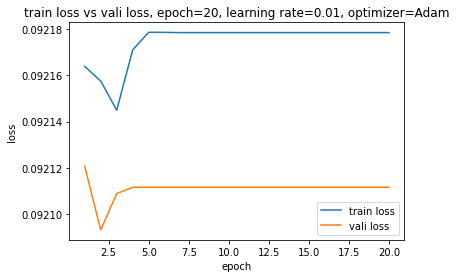

In [31]:
plt.figure()
x = range(1, true_epoch+1)
# print(true_epoch)
loss1, loss2 = train_loss_list, vali_loss_list
# print(loss1)
plt.title(f'train loss vs vali loss, epoch={true_epoch}, learning rate={learning_rate}, optimizer=Adam')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x, loss1, label='train loss')
plt.plot(x, loss2, label='vali loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()